## Milestone 02

- Class: BDA700NAA - Health Analytics
- Subject: Health Analytics Project - Milestone 02
- Members: Ran Arino, Zubeka Dane Dang

### Data Import



In [2]:
# Import libraries
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the API
api = KaggleApi()
api.authenticate()

# Download the dataset
# Format: api.dataset_download_files('username/dataset-name', path='./data')
if not os.path.exists('./data/brats20-dataset-training-validation.zip'):
    api.dataset_download_files('awsaf49/brats20-dataset-training-validation', path='./data')
    print("Dataset downloaded to ./data directory")
else:
    print("Dataset already exists in ./data directory")


Dataset already exists in ./data directory


### Explore Dataset

In [3]:
import nibabel as nib
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [5]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, validation=False, transform=None):
        self.root_dir = root_dir
        if validation:
            self.subject_dirs = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.startswith("BraTS20_Validation")]
        else:
            self.subject_dirs = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.startswith("BraTS20_Training")]
        self.transform = transform

    def __len__(self):
        return len(self.subject_dirs)

    def __getitem__(self, idx):
        subject_path = self.subject_dirs[idx]
        flair = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_flair.nii')).get_fdata()
        t1 = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t1.nii')).get_fdata()
        t1ce = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t1ce.nii')).get_fdata()
        t2 = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_t2.nii')).get_fdata()

        # For training data, we load segmentation masks
        if 'Training' in os.path.basename(subject_path):
            seg = nib.load(os.path.join(subject_path, f'{os.path.basename(subject_path)}_seg.nii')).get_fdata()

            # Extract tumor sub-regions
            et = (seg == 4).astype(float)  # Enhancing Tumor
            ed = (seg == 2).astype(float)  # Edema
            ncr_net = (seg == 1).astype(float)  # Necrotic/Non-enhancing Tumor
            segmentation = torch.tensor([et, ed, ncr_net], dtype=torch.float32)
        else:
            # No segmentation for validation data
            segmentation = None

        # Stack modalities along the channel dimension
        image = torch.tensor([flair, t1, t1ce, t2], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, segmentation

# Set dataset paths (adjust these paths based on where your data is extracted)
train_dataset_path = "./data/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
validation_dataset_path = "./data/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

# Create datasets
train_dataset = BraTSDataset(train_dataset_path)
validation_dataset = BraTSDataset(validation_dataset_path, validation=True)

# Testing the datasets
print("\nTesting Training Dataset:")
for i in range(3):
    try:
        image, segmentation = train_dataset[i]
        print(f"Loaded training sample {i} successfully")
        print(f"Image shape: {image.shape}")
        print(f"Segmentation shape: {segmentation.shape}")
    except FileNotFoundError as e:
        print(f"Error: {e}")

print("\nTesting Validation Dataset:")
for i in range(3):
    try:
        image, segmentation = validation_dataset[i]
        print(f"Loaded validation sample {i} successfully")
        print(f"Image shape: {image.shape}")
        if segmentation is None:
            print("No segmentation available (as expected)")
    except FileNotFoundError as e:
        print(f"Error: {e}")


Testing Training Dataset:


/var/folders/94/tj1gqv8s2nn5mbnb9k35_gvc0000gn/T/ipykernel_10513/3268004600.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  segmentation = torch.tensor([et, ed, ncr_net], dtype=torch.float32)


Loaded training sample 0 successfully
Image shape: torch.Size([4, 240, 240, 155])
Segmentation shape: torch.Size([3, 240, 240, 155])
Loaded training sample 1 successfully
Image shape: torch.Size([4, 240, 240, 155])
Segmentation shape: torch.Size([3, 240, 240, 155])
Loaded training sample 2 successfully
Image shape: torch.Size([4, 240, 240, 155])
Segmentation shape: torch.Size([3, 240, 240, 155])

Testing Validation Dataset:
Loaded validation sample 0 successfully
Image shape: torch.Size([4, 240, 240, 155])
No segmentation available (as expected)
Loaded validation sample 1 successfully
Image shape: torch.Size([4, 240, 240, 155])
No segmentation available (as expected)
Loaded validation sample 2 successfully
Image shape: torch.Size([4, 240, 240, 155])
No segmentation available (as expected)


### Data Visualization

In [18]:
# Visualization Function:
def visualize_data_sample(image, segmentation):
    # Get the middle slice along the axial direction
    slice_idx = image.shape[1] // 2

    # Extract modalities
    flair = image[0, slice_idx, :, :]
    t1 = image[1, slice_idx, :, :]
    t1ce = image[2, slice_idx, :, :]
    t2 = image[3, slice_idx, :, :]

    # Extract segmentation masks for different tumor regions
    et = segmentation[0, slice_idx, :, :]  # Enhancing Tumor
    ed = segmentation[1, slice_idx, :, :]  # Edema
    ncr_net = segmentation[2, slice_idx, :, :]  # Necrotic/Non-enhancing Tumor

    # Plotting MRI Modalities
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Plot FLAIR, T1, T1ce, T2
    axes[0, 0].imshow(flair, cmap='gray')
    axes[0, 0].set_title('FLAIR')

    axes[0, 1].imshow(t1, cmap='gray')
    axes[0, 1].set_title('T1')

    axes[0, 2].imshow(t1ce, cmap='gray')
    axes[0, 2].set_title('T1ce')

    axes[0, 3].imshow(t2, cmap='gray')
    axes[0, 3].set_title('T2')

    # Plot segmentation masks for each tumor sub-region
    axes[1, 0].imshow(et, cmap='hot')
    axes[1, 0].set_title('Enhancing Tumor (ET)')

    axes[1, 1].imshow(ed, cmap='hot')
    axes[1, 1].set_title('Edema (ED)')

    axes[1, 2].imshow(ncr_net, cmap='hot')
    axes[1, 2].set_title('Necrotic/Non-enhancing Tumor (NCR/NET)')

    # Overlay segmentation masks on FLAIR image
    axes[1, 3].imshow(flair, cmap='gray')
    axes[1, 3].imshow(et, cmap='Reds', alpha=0.5)
    axes[1, 3].imshow(ed, cmap='Greens', alpha=0.5)
    axes[1, 3].imshow(ncr_net, cmap='Blues', alpha=0.5)
    axes[1, 3].set_title('Overlay (FLAIR + Masks)')

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

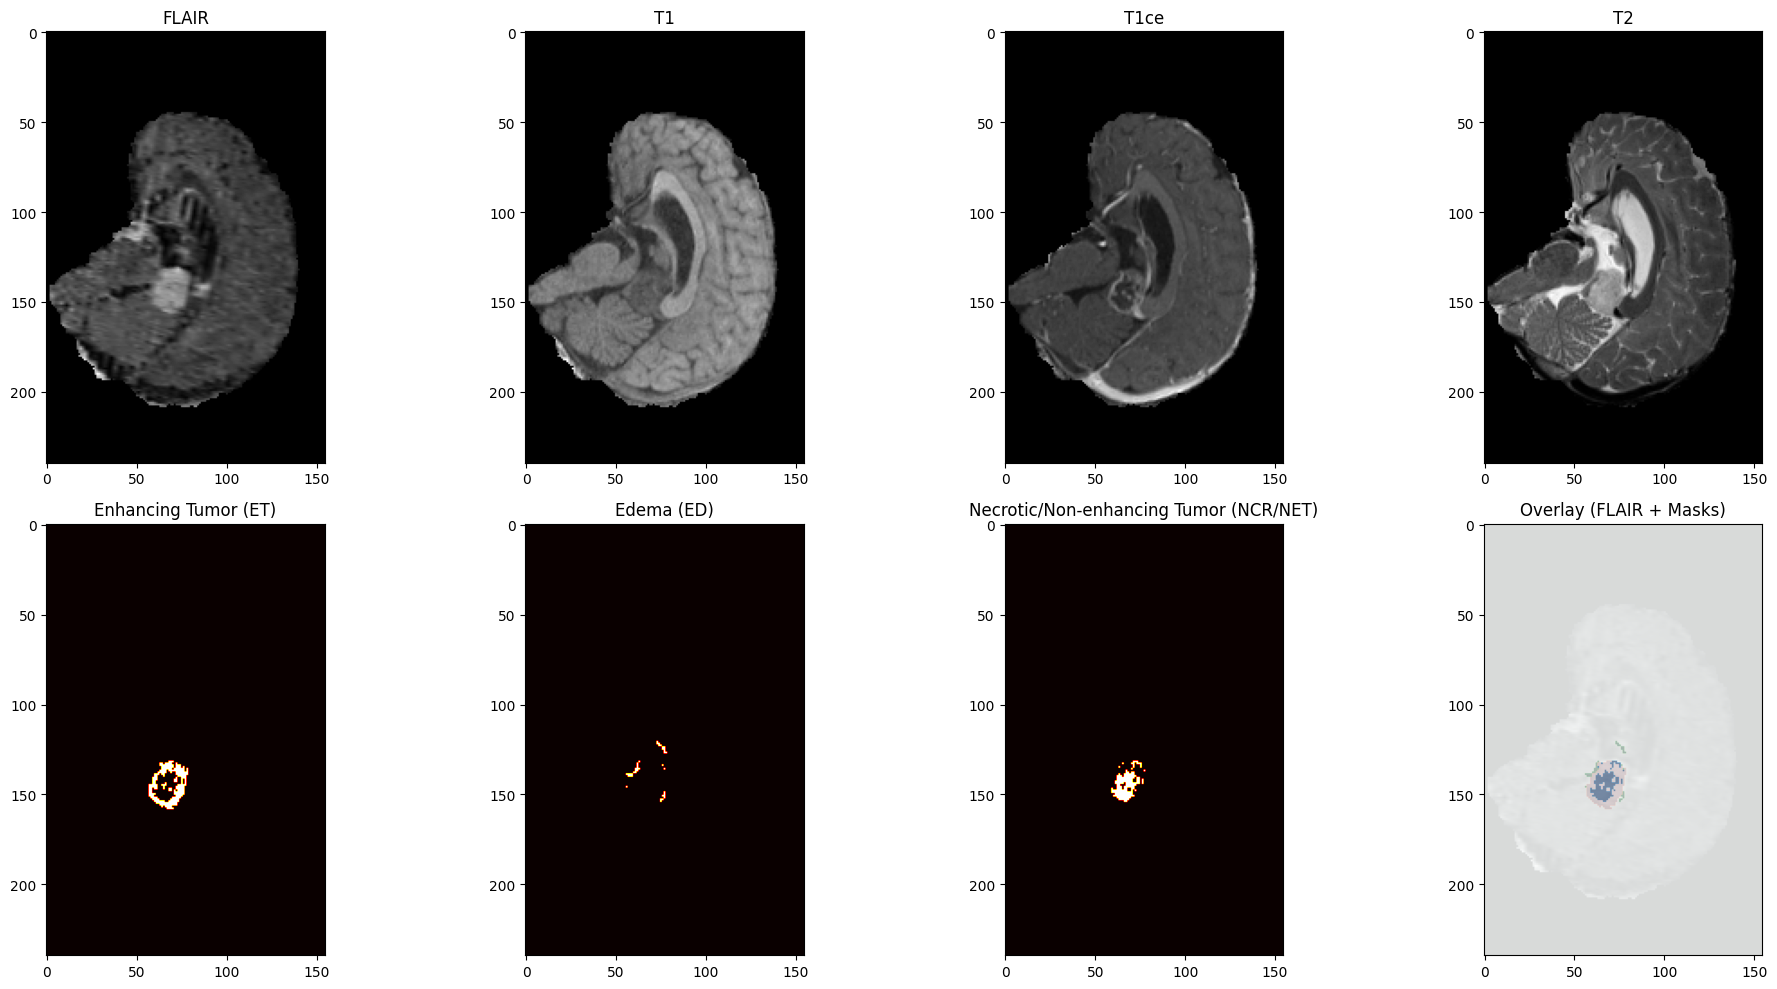

In [19]:
# Visualize a sample from the dataset with different MRI modalities
image, segmentation = train_dataset[0]
visualize_data_sample(image, segmentation)